In [1]:
import pandas_gbq
import pandas as pd
from google.oauth2 import service_account
import time
import pandas as pd
import time
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
plt.rc("font", size=14)
import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)
plt.style.use('fivethirtyeight')
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=["#B05E55"])
import plotly.graph_objects as go
import plotly.io as pio
from sklearn.preprocessing import MinMaxScaler
import shap
import lime
import lime.lime_tabular
from interpret.glassbox import ExplainableBoostingRegressor

start_time = time.time()

credentials = service_account.Credentials.from_service_account_file(
    # '/Users/michalkollar/prefect/gcp_secret.json',
    '../gcp_secret.json'
)

sql = """
SELECT *
FROM `trendspotting-294718.production.d_meebits_assets`
"""

df = pandas_gbq.read_gbq(sql, project_id="trendspotting-294718", credentials=credentials)



Downloading: 100%|██████████| 20053/20053 [00:06<00:00, 3309.68rows/s]


In [2]:

df['min_trait_count'] = df[['trait_countBeard', 'trait_countBeardColor',
       'trait_countEarring', 'trait_countGlasses', 'trait_countGlassesColor',
       'trait_countHairColor', 'trait_countHairStyle', 'trait_countHat',
       'trait_countHatColor', 'trait_countJerseyNumber', 'trait_countNecklace',
       'trait_countOvershirt', 'trait_countOvershirtColor',
       'trait_countPantsColor', 'trait_countShirtColor',
       'trait_countShoesColor', 'trait_countTattooMotif', 'trait_countType']].min(axis=1)

data = df[['sale_price', 'month_index', 'eth_price_usd', 'traits_number', 'num_sales', 'min_trait_count', 'trait_countBeard', 
       'trait_countBeardColor', 'trait_countEarring', 'trait_countGlasses', 'trait_countGlassesColor',
       'trait_countHairColor', 'trait_countHairStyle', 'trait_countHat',
       'trait_countHatColor', 'trait_countJerseyNumber', 'trait_countNecklace',
       'trait_countOvershirt', 'trait_countOvershirtColor',
       'trait_countPantsColor', 'trait_countShirtColor',
       'trait_countShoesColor', 'trait_countTattooMotif', 'trait_countType', 
       'valueBeard','valueBeardColor','valueEarring','valueGlasses','valueGlassesColor','valueHairColor',
       'valueHairStyle','valueHat','valueHatColor','valueNecklace','valueOvershirt',
       'valueOvershirtColor','valuePants','valuePantsColor',
       'valueShirt','valueShirtColor','valueShoes','valueShoesColor','valueType']]


# Split the dataset into categorical and numerical fields, convert dates to numerics
data = data.drop_duplicates(subset=None, keep='first')

# df['last_sale_date'] = pd.to_datetime(df['last_sale_date']).dt.to_period('M').dt.to_timestamp()

categories = data[['valueBeard','valueBeardColor','valueEarring','valueGlasses','valueGlassesColor','valueHairColor',
       'valueHairStyle','valueHat','valueHatColor','valueNecklace','valueOvershirt',
       'valueOvershirtColor','valuePants','valuePantsColor',
       'valueShirt','valueShirtColor','valueShoes','valueShoesColor','valueType']].fillna('None')


target = data[['sale_price']]

numericals = data[['month_index', 'eth_price_usd', 'traits_number', 'num_sales', 'min_trait_count', 'trait_countBeard', 
       'trait_countBeardColor', 'trait_countEarring', 'trait_countGlasses', 'trait_countGlassesColor',
       'trait_countHairColor', 'trait_countHairStyle', 'trait_countHat',
       'trait_countHatColor', 'trait_countJerseyNumber', 'trait_countNecklace',
       'trait_countOvershirt', 'trait_countOvershirtColor',
       'trait_countPantsColor', 'trait_countShirtColor',
       'trait_countShoesColor', 'trait_countTattooMotif', 'trait_countType']]



In [3]:

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

data.loc[:,numericals.columns] = scaler.fit_transform(data.loc[:,numericals.columns])

data = pd.get_dummies(data, columns = categories.columns)

In [4]:

numericals = data[['month_index', 'eth_price_usd', 'traits_number', 'num_sales', 'min_trait_count', 'trait_countBeard', 
       'trait_countBeardColor', 'trait_countEarring', 'trait_countGlasses', 'trait_countGlassesColor',
       'trait_countHairColor', 'trait_countHairStyle', 'trait_countHat',
       'trait_countHatColor', 'trait_countJerseyNumber', 'trait_countNecklace',
       'trait_countOvershirt', 'trait_countOvershirtColor',
       'trait_countPantsColor', 'trait_countShirtColor',
       'trait_countShoesColor', 'trait_countTattooMotif', 'trait_countType']]

import re
data = data.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))


In [5]:
# Look for highly correlated pairs
pd.set_option('display.max_rows', 100)
corr_matrix = df[numericals.columns].corr().abs()

sol = (corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
                  .stack()
                  .sort_values(ascending=False))
    
print(sol[:30])


trait_countBeard         trait_countBeardColor        0.974926
trait_countHat           trait_countHatColor          0.950598
trait_countOvershirt     trait_countOvershirtColor    0.713373
trait_countGlasses       trait_countGlassesColor      0.516219
traits_number            trait_countBeard             0.435609
                         trait_countBeardColor        0.433117
                         trait_countHatColor          0.422181
                         trait_countHat               0.420389
trait_countHairStyle     trait_countHat               0.412442
                         trait_countHatColor          0.396859
traits_number            trait_countGlasses           0.381274
                         min_trait_count              0.371198
                         trait_countGlassesColor      0.332411
                         trait_countOvershirtColor    0.310184
                         trait_countOvershirt         0.308335
min_trait_count          trait_countTattooMotif       0

`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


In [6]:
data = data.drop(columns=['trait_countBeard','trait_countHat'])
numericals = numericals.drop(columns=['trait_countBeard','trait_countHat'])


In [7]:
data_sold = data[data['sale_price'].notnull()]
# data_sold = data_sold[['sale_price','valueType_DoublePig','valueType_Visitor','trait_countType','valueType_Human','valueType_Skeleton','valueType_Robot','valueShirt_GlyphShirt','valueType_Elephant','valueType_Pig','valueShirtColor_Magenta','valueGlasses_3D',
#     'valueOvershirtColor_Posh','trait_countOvershirt','valueHairStyle_Fade','trait_countHat','valueShoesColor_Purple','valueBeard_MedicalMask','valueOvershirtColor_GreenPlaid',
#     'valueShirt_PunkTee','valueShirt_HoodieUp','valueShoes_Basketball','valueShirtColor_Camo','month_index','valueHat_WoolHat','valueHairColor_DyedRed','valueNecklace_GoldChain','valueShirt_Jersey',
#     'valueBeardColor_Silver','valuePants_CargoPants','valueShirtColor_Black','valuePantsColor_Magenta','valueHat_Cap','trait_countJerseyNumber','valueShoes_LL86','valueShoes_Classic',
#     'valueShirt_CGAShirt','eth_price_usd','valueShoes_LLMoonboots','valueOvershirtColor_Yellow','valuePantsColor_Argyle','trait_countShirtColor','valueShirt_FlamingoTee','valueHatColor_Camo','valueShirt_Lines',
#     'valueShoes_LLAlien','trait_countGlasses','trait_countBeard','valueGlassesColor_Charcoal','trait_countNecklace','valuePantsColor_BlueCamo','min_trait_count','valuePants_SuitPants',
#     'traits_number','valueShirt_InvaderTee','valuePantsColor_Camo','valueShirt_Windbreaker','valueHat_Headphones','valueShirt_Suit','valueShirt_SnoutzHoodie','valueShoesColor_White',
#     'valueHatColor_Magenta','valueShirt_TiedyedTee','valueShirt_Hawaiian','trait_countPantsColor','valueShirtColor_White','valueShirt_SnoutzSkullTee','valueEarring_GoldEarring','valueHat_SnoutzCap',
#     'valueShirtColor_Luxe','valueOvershirtColor_Argyle','valuePantsColor_Yellow','valueOvershirtColor_Magenta','valueShirtColor_Posh','valueHairColor_Blue','valueHatColor_Purple','valueShoesColor_Magenta',
#     'valueHat_BackwardsCap','valueHatColor_White','trait_countHairColor','valueShoes_LLRGB','valueHatColor_Gray','trait_countHairStyle','valueBeard_Full','valueShirt_StylizedHoodie','valuePantsColor_Purple']]


In [8]:
# takes out roughly 3% of the sales with lowest price - these seem not to be valid
data_sold = data_sold[data_sold['sale_price']>=0.1]


In [9]:
df_na = (data_sold.isnull().sum() / len(data_sold)) * 100
df_na = df_na.drop(df_na[df_na == 0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({'Missing Ratio' :df_na})
missing_data

Empty DataFrame
Columns: [Missing Ratio]
Index: []

In [10]:
data_sold.groupby(['trait_countType','valueType_DoublePig','valueType_Dissected','valueType_Visitor','valueType_Robot']).size()


trait_countType  valueType_DoublePig  valueType_Dissected  valueType_Visitor  valueType_Robot
0.000000         1                    0                    0                  0                     1
0.000212         0                    1                    0                  0                     1
0.000900         0                    0                    1                  0                     9
0.002966         0                    0                    0                  0                    22
0.003761         0                    0                    0                  1                    31
0.013506         0                    0                    0                  0                   123
0.037606         0                    0                    0                  0                   311
1.000000         0                    0                    0                  0                  8461
dtype: int64

In [11]:
is_doublepig = data_sold['valueType_DoublePig'] == 1
df_doublepig = data_sold[is_doublepig]
data_sold_duplicates = data_sold.append([df_doublepig]*11,ignore_index=True)

is_dissected = data_sold['valueType_Dissected']==1
df_dissected = data_sold[is_dissected]
data_sold_duplicates = data_sold_duplicates.append([df_dissected]*11,ignore_index=True)

is_visitor = data_sold['valueType_Visitor']==1
df_visitor = data_sold[is_visitor]
data_sold_duplicates = data_sold_duplicates.append([df_visitor],ignore_index=True)

In [12]:
X = data_sold_duplicates.drop(['sale_price'],axis=1)
X = X[['valueType_DoublePig','valueType_Visitor','trait_countType','valueType_Robot','valueShirt_CGAShirt','valueType_Human','valueShirt_GlyphShirt','valueType_Skeleton','valueShoes_NeonSneakers','valueShoes_LLAlien',
'valueBeardColor_Blond','valueHat_Headphones','valueGlasses_3D','valueOvershirtColor_Posh','valueNecklace_GoldChain','valueHairStyle_FieryMohawk','valueHairStyle_Bald','valueShirt_PunkTee','valueShirt_HoodieUp',
'valueShirtColor_Black','valueBeard_MedicalMask','valueType_Elephant','trait_countBeardColor','trait_countOvershirtColor','valueHat_TruckerCap','valueShoes_LL86','valueShoesColor_White',
'trait_countGlasses','month_index','eth_price_usd','min_trait_count','valueHatColor_Gray','valueOvershirtColor_White','traits_number','valueShirtColor_Gray','valueBeardColor_Silver','valueShirt_SnoutzHoodie','valuePants_RegularPants','valueType_Pig',
'valueShirt_FlamingoTee','valueGlassesColor_Charcoal','valuePantsColor_Camo','valueOvershirtColor_Argyle','valuePantsColor_BlueCamo','valueHat_Cap','valuePants_RippedJeans','valueShoes_Classic',
'num_sales','valuePants_SuitPants','valueShoes_LLMoonboots','valueBeard_Mustache','trait_countTattooMotif','valueShirtColor_White','valueHairColor_DyedRed','valuePants_CargoPants','valueShirtColor_BlueCamo',
'valueShirtColor_Camo','valueOvershirtColor_Luxe','valueShoesColor_Gray','valueShirt_TiedyedTee','valueShirt_Hoodie','valueHairStyle_Halfshaved','trait_countHairStyle','valueShoesColor_Purple','valueHat_SnoutzCap',
'valueBeard_BikerMustache','valueHairStyle_Mohawk','valueGlassesColor_White','valueShoesColor_Yellow','valueShirtColor_Argyle','valueShoes_Running','valueShirt_InvaderTee','trait_countHatColor','valueGlasses_Elvis',
'valueShoes_LLBabyBlue','valueHairColor_Blond','valueShirtColor_Green','valueHairColor_Blonde','valueHatColor_Red','valueEarring_GoldEarring','trait_countShoesColor','valueShirt_Hawaiian','trait_countHairColor',
'trait_countShirtColor','valueOvershirtColor_GreenPlaid','valueHatColor_Yellow','valueHat_BackwardsCap','valueHat_WoolHat','valueShoes_Canvas','valueShirt_SnoutzTee','valuePantsColor_Argyle','trait_countPantsColor',
'valueShirt_SkullTee','valueBeard_Muttonchops','valueHairColor_Blue','valueShirtColor_Yellow','valueShoes_LLRGB','valueShirt_GhostTee','valueHatColor_White','valueGlasses_Specs','valueOvershirtColor_BlueCamo',
'valueHatColor_Purple','valuePantsColor_Yellow','valueShirt_Jersey','valueShoes_Sneakers','valueShirtColor_Posh','valueShirt_StylizedHoodie','valueHairColor_Dark','valueOvershirtColor_RedPlaid','valueShirt_HeartTee',
'valueHairStyle_VeryLong','valueShoes_Basketball','valuePantsColor_DarkRed','valueHat_Brimmed','valuePants_Trackpants','valueShirt_Suit','valuePantsColor_Purple','valuePants_Skirt','valuePantsColor_DarkGray','trait_countOvershirt',
'valuePants_AthleticShorts','valueShirtColor_LeopardPrint','valueShoes_LLHighTops','valuePantsColor_GreenPlaid','trait_countNecklace','valueHat_Bandana','valueBeard_Big','valueHatColor_Black','valueOvershirtColor_Red','valueOvershirtColor_Black','valuePantsColor_Gray']]

y = data_sold_duplicates[['sale_price']]

In [13]:
X.groupby(['trait_countType','valueType_DoublePig','valueType_Visitor','valueType_Robot']).size()


trait_countType  valueType_DoublePig  valueType_Visitor  valueType_Robot
0.000000         1                    0                  0                    12
0.000212         0                    0                  0                    12
0.000900         0                    1                  0                    18
0.002966         0                    0                  0                    22
0.003761         0                    0                  1                    31
0.013506         0                    0                  0                   123
0.037606         0                    0                  0                   311
1.000000         0                    0                  0                  8461
dtype: int64

In [14]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import train_test_split

In [15]:
# Train, test, val split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, stratify=X['trait_countType'])
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42, stratify=X_train['trait_countType'])

In [50]:
# Run the features vol. evaluation
from numpy import sort
from numpy import absolute

# !{sys.executable} -m pip install -qU 'xgboost'
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, RepeatedKFold, cross_val_score
from sklearn.metrics import r2_score, explained_variance_score, max_error, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn.feature_selection import SelectFromModel
from sklearn import metrics

#interpretml 
from interpret import show
from interpret.data import Marginal
from interpret.glassbox import ExplainableBoostingRegressor, LinearRegression, RegressionTree

model = ExplainableBoostingRegressor(random_state=1, n_jobs=-1, interactions=0)

# define model evaluation method
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(model, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)

# force scores to be positive
scores = absolute(scores)
print('Mean MAE: %.3f (%.3f)' % (scores.mean(), scores.std()))

model.fit(X_train, y_train)
# make predictions for test data and evaluate
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]
r2 = r2_score(y_test, predictions)
explained_variance = explained_variance_score(y_test, predictions)
max_err = max_error(y_test, predictions)
mean_absolute_err = mean_absolute_error(y_test, predictions)
mean_squared_err = mean_squared_error(y_test, predictions)
mean_absolute_percentage_err = mean_absolute_percentage_error(y_test, predictions)

print("r2_score: %.2f" % (r2 * 100.0))
print("explained_variance_score: %.2f" % (explained_variance * 100.0))
print("max_error: %.2f" % (max_err))
print("mean_absolute_error: %.2f" % (mean_absolute_err))
print("mean_squared_error: %.2f" % (mean_squared_err))
print("mean_absolute_percentage_error: %.2f" % (mean_absolute_percentage_err * 100.0))

# Fit model using each importance as a threshold
thresholds = [0.9,0.8,0.7,0.6,0.5,0.4,0.3,0.2,0.1,0.05,0.01]

ebm_global = model.explain_global(name='EBM')

importances = ebm_global.data(-1)['overall']
importances = pd.DataFrame(importances).sort_values(by=['scores'], ascending=False)
length = len(importances.reset_index())

metrics = []

for thresh in thresholds:
    # select features using threshold
    selection = importances.reset_index(drop=True)[:round(length*thresh)]
    selection = selection['names'].to_list()

    select_X_train = X_train[selection]
    # train model
    selection_model = ExplainableBoostingRegressor(random_state=1, n_jobs=-1)

    selection_model.fit(select_X_train, y_train.values.ravel())
    # eval model
    select_X_test = X_test[selection]
    y_pred = selection_model.predict(select_X_test)
    # y_pred
    predictions = [round(value) for value in y_pred]
    explained_variance_s = explained_variance_score(y_test, predictions)
    mean_absolute_er = mean_absolute_error(y_test, predictions)
    mean_absolute_percentage_er = mean_absolute_percentage_error(y_test, predictions)
    metrics.append([select_X_train.shape[1],explained_variance_s*100.0,mean_absolute_er,mean_absolute_percentage_er*100.0])

results = pd.DataFrame(metrics, columns=['features','explained_variance_score','mean_absolute_error','mean_absolute_percentage_error'])

Mean MAE: 3.435 (0.317)
r2_score: 93.76
explained_variance_score: 93.76
max_error: 233.75
mean_absolute_error: 3.26
mean_squared_error: 114.95
mean_absolute_percentage_error: 548.97


In [52]:
# results[(results['features'] < 200) & (results['features'] > 2)]
results[(results['mean_absolute_error'] < 5.67) & (results['features'] < 300)]

features  explained_variance_score  mean_absolute_error  \
0        118                 96.020786             2.845894   
1        105                 96.046750             2.856924   
2         92                 96.029623             2.847803   
3         79                 96.048880             2.857748   
4         66                 96.065374             2.847626   
5         52                 96.082614             2.829503   
6         39                 96.092146             2.765793   
7         26                 95.887819             2.658458   
8         13                 95.634916             2.620815   
9          7                 90.476179             2.645267   
10         1                 93.646094             3.484588   

    mean_absolute_percentage_error  
0                       435.125741  
1                       435.333512  
2                       431.502720  
3                       431.812436  
4                       427.840873  
5                       433.130428  
6                       419.253670  
7                       419.623144  
8                       408.043212  
9                       397.393001  
10                      596.667079

In [55]:
lowest_num_features = 131
features = importances.reset_index(drop=True)[:lowest_num_features]
features = features['names'].to_list()
feature_selection = features


In [56]:
X_train = X_train[feature_selection]
X_test = X_test[feature_selection]
X_val = X_val[feature_selection]

In [72]:
def objective(trial,data=data,target=target):
    
    # train_x, test_x, train_y, test_y = train_test_split(X, y, test_size=0.15,random_state=42)
    param = {
        # 'tree_method':'gpu_hist',  # this parameter means using the GPU when training our model to speedup the training process
        'max_bins': trial.suggest_categorical('max_bins', [16, 32, 64, 128, 256, 512, 1024]),
        'max_interaction_bins': trial.suggest_categorical('max_interaction_bins', [2, 4, 8, 16, 32, 64, 128]),
        'binning': trial.suggest_categorical('binning', ['quantile','uniform']),
        'interactions': trial.suggest_int('interactions', 0, 1),
        'outer_bags': trial.suggest_categorical('outer_bags', [4, 32, 2]),
        'inner_bags': trial.suggest_int('inner_bags', 0, 8, 2),
        'learning_rate': trial.suggest_categorical('learning_rate', [0.008,0.01,0.012,0.016, 0.02, 0.1, 0.2, 0.3]),
        'early_stopping_tolerance': trial.suggest_loguniform('early_stopping_tolerance', 1e-5, 1),
        'min_samples_leaf': trial.suggest_categorical('min_samples_leaf', [2, 4]),
        'max_leaves': trial.suggest_categorical('max_leaves', [3, 4, 5])
    }
    model = ExplainableBoostingRegressor(**param,early_stopping_rounds=50)  
    
    model.fit(X_train,y_train)
    
    preds = model.predict(X_test)
    
    rmse = mean_squared_error(y_test, preds,squared=False)
    mae = mean_absolute_error(y_test, preds)

    return mae

In [73]:
import optuna
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, RepeatedKFold, cross_val_score
from sklearn.metrics import r2_score, explained_variance_score, max_error, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn.feature_selection import SelectFromModel
from sklearn import metrics

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=1000)
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)

[I 2022-01-20 20:22:01,542] A new study created in memory with name: no-name-5bb46f16-2d45-4785-aba0-a4351a4f7afb
[I 2022-01-20 20:22:12,893] Trial 0 finished with value: 3.6159136566739445 and parameters: {'max_bins': 512, 'max_interaction_bins': 2, 'binning': 'uniform', 'interactions': 1, 'outer_bags': 2, 'inner_bags': 0, 'learning_rate': 0.1, 'early_stopping_tolerance': 0.030782253786534555, 'min_samples_leaf': 2, 'max_leaves': 4}. Best is trial 0 with value: 3.6159136566739445.
[I 2022-01-20 20:23:15,882] Trial 1 finished with value: 3.395952796437859 and parameters: {'max_bins': 512, 'max_interaction_bins': 16, 'binning': 'quantile', 'interactions': 1, 'outer_bags': 4, 'inner_bags': 4, 'learning_rate': 0.012, 'early_stopping_tolerance': 0.0032358676705960972, 'min_samples_leaf': 4, 'max_leaves': 4}. Best is trial 1 with value: 3.395952796437859.
[I 2022-01-20 20:23:21,458] Trial 2 finished with value: 3.3186660836568205 and parameters: {'max_bins': 128, 'max_interaction_bins': 4, 

Number of finished trials: 1000
Best trial: {'max_bins': 1024, 'max_interaction_bins': 8, 'binning': 'quantile', 'interactions': 1, 'outer_bags': 32, 'inner_bags': 0, 'learning_rate': 0.02, 'early_stopping_tolerance': 0.0011189101121135353, 'min_samples_leaf': 2, 'max_leaves': 3}


In [74]:
Best_trial = study.best_trial.params


In [75]:
Best_trial

# MAE= {'max_bins': 1024,
#  'max_interaction_bins': 8,
#  'binning': 'quantile',
#  'interactions': 1,
#  'outer_bags': 32,
#  'inner_bags': 0,
#  'learning_rate': 0.02,
#  'early_stopping_tolerance': 0.0011189101121135353,
#  'min_samples_leaf': 2,
#  'max_leaves': 3}

# RMSE = {'lambda': 0.0272568194036206,
#  'alpha': 0.1571686364023956,
#  'colsample_bytree': 1.0,
#  'subsample': 0.6,
#  'learning_rate': 0.3,
#  'n_estimators': 283,
#  'eta': 0.1,
#  'max_depth': 20,
#  'random_state': 24,
#  'min_child_weight': 1}

{'max_bins': 1024,
 'max_interaction_bins': 8,
 'binning': 'quantile',
 'interactions': 1,
 'outer_bags': 32,
 'inner_bags': 0,
 'learning_rate': 0.02,
 'early_stopping_tolerance': 0.0011189101121135353,
 'min_samples_leaf': 2,
 'max_leaves': 3}

In [77]:
# evaluate xgboost ensemble for regression
from numpy import mean
from numpy import std
from sklearn.model_selection import cross_val_score, RepeatedKFold
from xgboost import XGBRegressor
# define dataset
from interpret.glassbox import ExplainableBoostingRegressor, LinearRegression, RegressionTree

MAE= {'max_bins': 1024,
    'max_interaction_bins': 8,
    'binning': 'quantile',
    'interactions': 1,
    'outer_bags': 32,
    'inner_bags': 0,
    'learning_rate': 0.02,
    'early_stopping_tolerance': 0.0011189101121135353,
    'min_samples_leaf': 2,
    'max_leaves': 3
}

model = ExplainableBoostingRegressor(**MAE,random_state=1, n_jobs=-1)

# model = XGBRegressor(n_estimators=1000, max_depth=7, eta=0.1, subsample=0.7, colsample_bytree=0.8)

# evaluate the model
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(model, X_train, y_train, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1, error_score='raise')
# report performance
print('MAE: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

# 1. MAE: -1.772 (0.405) - XGBOOST
# 2. MAE: -2.030 (0.388) - XGBOOST
# 2. MAE: -3.344 (0.317) - EBM

MAE: -3.344 (0.317)


In [82]:
# fit the model on the whole dataset
model.fit(X_train, y_train)
# make a prediction
prediction = model.predict(X_test)


In [76]:
y_test.loc[:,'pred_price'] = prediction

NameError: name 'prediction' is not defined

In [84]:
y_test

sale_price  pred_price
12314    1.970000    2.624744
1974     1.750000    2.069296
15482    2.890000    2.613449
2737     3.940000    3.934415
9248     1.800000    1.902006
...           ...         ...
1865     0.793704    1.331259
14301    6.750000   12.255918
5173     6.420000    6.367440
10606   10.000000    9.587993
2778     2.350000    3.241274

[729 rows x 2 columns]

In [65]:
print("--- %s seconds ---" % (time.time() - start_time))

--- 13361.491527080536 seconds ---


In [85]:
# save to JSON
model.save_model("models/meebits_xgb_model.json")

In [15]:
from xgboost import XGBRegressor

model2 = XGBRegressor()
model2.load_model("models/meebits_xgb_model.json")
model2.fit(X_train,y_train,eval_set=[(X_test,y_test)],early_stopping_rounds=100,verbose=False)



In [16]:
feature_selection = ['valueType_DoublePig','valueType_Visitor','trait_countType','valueType_Robot','valueShirt_CGAShirt','valueType_Human','valueShirt_GlyphShirt','valueType_Skeleton','valueShoes_NeonSneakers','valueShoes_LLAlien',
    'valueBeardColor_Blond','valueHat_Headphones','valueGlasses_3D','valueOvershirtColor_Posh','valueNecklace_GoldChain','valueHairStyle_FieryMohawk','valueHairStyle_Bald','valueShirt_PunkTee','valueShirt_HoodieUp',
    'valueShirtColor_Black','valueBeard_MedicalMask','valueType_Elephant','trait_countBeardColor','trait_countOvershirtColor','valueHat_TruckerCap','valueShoes_LL86','valueShoesColor_White',
    'trait_countGlasses','month_index','eth_price_usd','min_trait_count','valueHatColor_Gray','valueOvershirtColor_White','traits_number','valueShirtColor_Gray','valueBeardColor_Silver','valueShirt_SnoutzHoodie','valuePants_RegularPants','valueType_Pig',
    'valueShirt_FlamingoTee','valueGlassesColor_Charcoal','valuePantsColor_Camo','valueOvershirtColor_Argyle','valuePantsColor_BlueCamo','valueHat_Cap','valuePants_RippedJeans','valueShoes_Classic',
    'num_sales','valuePants_SuitPants','valueShoes_LLMoonboots','valueBeard_Mustache','trait_countTattooMotif','valueShirtColor_White','valueHairColor_DyedRed','valuePants_CargoPants','valueShirtColor_BlueCamo',
    'valueShirtColor_Camo','valueOvershirtColor_Luxe','valueShoesColor_Gray','valueShirt_TiedyedTee','valueShirt_Hoodie','valueHairStyle_Halfshaved','trait_countHairStyle','valueShoesColor_Purple','valueHat_SnoutzCap',
    'valueBeard_BikerMustache','valueHairStyle_Mohawk','valueGlassesColor_White','valueShoesColor_Yellow','valueShirtColor_Argyle','valueShoes_Running','valueShirt_InvaderTee','trait_countHatColor','valueGlasses_Elvis',
    'valueShoes_LLBabyBlue','valueHairColor_Blond','valueShirtColor_Green','valueHairColor_Blonde','valueHatColor_Red','valueEarring_GoldEarring','trait_countShoesColor','valueShirt_Hawaiian','trait_countHairColor',
    'trait_countShirtColor','valueOvershirtColor_GreenPlaid','valueHatColor_Yellow','valueHat_BackwardsCap','valueHat_WoolHat','valueShoes_Canvas','valueShirt_SnoutzTee','valuePantsColor_Argyle','trait_countPantsColor',
    'valueShirt_SkullTee','valueBeard_Muttonchops','valueHairColor_Blue','valueShirtColor_Yellow','valueShoes_LLRGB','valueShirt_GhostTee','valueHatColor_White','valueGlasses_Specs','valueOvershirtColor_BlueCamo',
    'valueHatColor_Purple','valuePantsColor_Yellow','valueShirt_Jersey','valueShoes_Sneakers','valueShirtColor_Posh','valueShirt_StylizedHoodie','valueHairColor_Dark','valueOvershirtColor_RedPlaid','valueShirt_HeartTee',
    'valueHairStyle_VeryLong','valueShoes_Basketball','valuePantsColor_DarkRed','valueHat_Brimmed','valuePants_Trackpants','valueShirt_Suit','valuePantsColor_Purple','valuePants_Skirt','valuePantsColor_DarkGray','trait_countOvershirt',
    'valuePants_AthleticShorts','valueShirtColor_LeopardPrint','valueShoes_LLHighTops','valuePantsColor_GreenPlaid','trait_countNecklace','valueHat_Bandana','valueBeard_Big','valueHatColor_Black','valueOvershirtColor_Red','valueOvershirtColor_Black','valuePantsColor_Gray']

X_train = X_train[feature_selection]
X_test = X_test[feature_selection]
X_val = X_val[feature_selection]

In [19]:
X_test.columns

Index(['valueType_DoublePig', 'valueType_Visitor', 'trait_countType',
       'valueType_Robot', 'valueShirt_CGAShirt', 'valueType_Human',
       'valueShirt_GlyphShirt', 'valueType_Skeleton',
       'valueShoes_NeonSneakers', 'valueShoes_LLAlien',
       ...
       'valueShirtColor_LeopardPrint', 'valueShoes_LLHighTops',
       'valuePantsColor_GreenPlaid', 'trait_countNecklace', 'valueHat_Bandana',
       'valueBeard_Big', 'valueHatColor_Black', 'valueOvershirtColor_Red',
       'valueOvershirtColor_Black', 'valuePantsColor_Gray'],
      dtype='object', length=131)

In [22]:
# shap_values = shap.TreeExplainer(model).shap_values(X_train)
# shap_values = explainer(X_test)

import lime
import lime.lime_tabular

class_names = X_train.columns
X_train2 = X_train.to_numpy()
X_test2 = X_test.to_numpy()
y_train2 = y_train.to_numpy()
y_test2 = y_test.to_numpy()

explainer = lime.lime_tabular.LimeTabularExplainer(X_test2, feature_names=class_names, verbose=True, mode='regression')


In [ ]:
exp = explainer.explain_instance(X_test2[0], model2.predict, num_features=131)
exp.show_in_notebook(show_table=True)

In [23]:
X_test[X_test['valueType_Pig']==1]

valueType_DoublePig  valueType_Visitor  trait_countType  \
1275                     0                  0         0.037606   
12072                    0                  0         0.037606   
9043                     0                  0         0.037606   
9936                     0                  0         0.037606   
7019                     0                  0         0.037606   
16548                    0                  0         0.037606   

       valueType_Robot  valueShirt_CGAShirt  valueType_Human  \
1275                 0                    0                0   
12072                0                    0                0   
9043                 0                    0                0   
9936                 0                    0                0   
7019                 0                    0                0   
16548                0                    0                0   

       valueShirt_GlyphShirt  valueType_Skeleton  valueShoes_NeonSneakers  \
1275                       0                   0                        0   
12072                      0                   0                        0   
9043                       0                   0                        1   
9936                       0                   0                        0   
7019                       0                   0                        0   
16548                      0                   0                        0   

       valueShoes_LLAlien  ...  valueShirtColor_LeopardPrint  \
1275                    0  ...                             0   
12072                   0  ...                             0   
9043                    0  ...                             0   
9936                    0  ...                             0   
7019                    0  ...                             0   
16548                   0  ...                             0   

       valueShoes_LLHighTops  valuePantsColor_GreenPlaid  trait_countNecklace  \
1275                       0                           0             0.039768   
12072                      0                           0             0.039768   
9043                       0                           0             1.000000   
9936                       0                           0             1.000000   
7019                       0                           0             1.000000   
16548                      0                           0             1.000000   

       valueHat_Bandana  valueBeard_Big  valueHatColor_Black  \
1275                  0               0                    0   
12072                 0               0                    0   
9043                  0               0                    1   
9936                  0               0                    0   
7019                  0               0                    0   
16548                 0               0                    0   

       valueOvershirtColor_Red  valueOvershirtColor_Black  \
1275                         0                          0   
12072                        0                          0   
9043                         0                          0   
9936                         0                          0   
7019                         0                          0   
16548                        0                          0   

       valuePantsColor_Gray  
1275                      0  
12072                     0  
9043                      0  
9936                      0  
7019                      0  
16548                     0  

[6 rows x 131 columns]

In [26]:
shap_values = shap.TreeExplainer(model2).shap_values(X_test)
shap = pd.DataFrame(shap_values, columns='shap_'+X_test.columns, index= X_test.index)


shap_valueType_DoublePig  shap_valueType_Visitor  shap_trait_countType  \
9043                 -0.127262               -0.074149              9.162963   

      shap_valueType_Robot  shap_valueShirt_CGAShirt  shap_valueType_Human  \
9043             -0.042802                  0.004868                   0.0   

      shap_valueShirt_GlyphShirt  shap_valueType_Skeleton  \
9043                   -0.045674                 0.000438   

      shap_valueShoes_NeonSneakers  shap_valueShoes_LLAlien  ...  \
9043                      0.216005                      0.0  ...   

      shap_valueShirtColor_LeopardPrint  shap_valueShoes_LLHighTops  \
9043                                0.0                   -0.002612   

      shap_valuePantsColor_GreenPlaid  shap_trait_countNecklace  \
9043                        -0.000767                  0.001971   

      shap_valueHat_Bandana  shap_valueBeard_Big  shap_valueHatColor_Black  \
9043              -0.004273            -0.011558                 -0.146622   

      shap_valueOvershirtColor_Red  shap_valueOvershirtColor_Black  \
9043                     -0.000612                        0.000283   

      shap_valuePantsColor_Gray  
9043                  -0.004308  

[1 rows x 131 columns]

In [27]:
vals = np.abs(shap_values.values).mean(0)
feature_names = X_test.columns()

feature_importance = pd.DataFrame(list(zip(feature_names, vals)),
                                  columns=['col_name','feature_importance_vals'])
feature_importance.sort_values(by=['feature_importance_vals'],
                               ascending=False, inplace=True)
feature_importance.head()

TypeError: 'Index' object is not callable

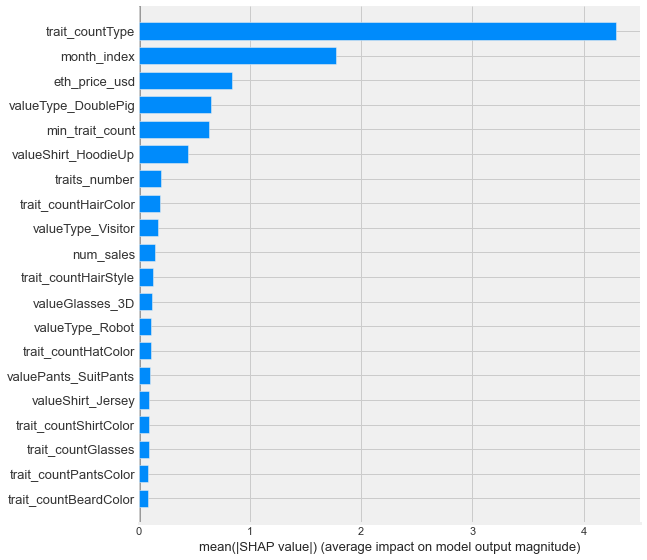

In [24]:
shap.summary_plot(shap_values, X_test, plot_type="bar")


In [18]:
prediction = model2.predict(X_test)
y_test.loc[:,'pred_price'] = prediction


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [20]:
y_test

sale_price  pred_price
9370     4.000000    4.002011
1045     5.000000    6.238831
18621    5.100000    5.098691
13837    3.987502    3.981123
75      15.990000   15.991756
...           ...         ...
15823    4.200000    4.337105
1152     3.980000    3.980533
12932    3.400000    3.404217
11573    9.990000    9.982664
16738   15.500000   15.499721

[755 rows x 2 columns]

In [75]:
colors = ['#ee0000','#edc951','#00a0b0','#336699','#8d2867','#949494','#4f372d','#eb6841','#2d454f']

y_test_sorted = y_test[y_test['sale_price'] <= y_test['sale_price'].quantile(q=0.99, interpolation='linear').round(0)]
y_test_sorted = y_test_sorted.sort_values(by=['sale_price'], ascending=False)

fig = go.Figure()

fig.add_trace(go.Scatter(
                    name="Sale Price",
                    # x = y_test_sorted['valuetype'],
                    y = y_test_sorted['sale_price'].round(3),
                    mode = 'markers',
                    marker = dict(
                        size = 8
                        ,color = '#336699'
                        ,line = dict(width=0.2, color='#fff')
                        ,opacity=0.8
                    ),
                    hovertemplate=
                    "<b>%{x}</b><br>" +
                    "Sale price (ETH): %{y:,2}<br>" +
                    "<extra></extra>"
                    )
                )
fig.add_trace(go.Scatter(
                    name="Predicted Price",
                    # x=y_test_sorted['valuetype'],
                    y=y_test_sorted['pred_price'].round(3),
                    mode = 'markers',
                    marker = dict(
                        size = 8
                        ,color = '#ee0000'
                        ,line= dict(width=0.5, color='#fff')
                        ,opacity=0.3
                    ),                
                    hovertemplate=
                    "<b>%{x}</b><br>" +
                    "Prediction: %{y:,0}<br>" +
                    "<extra></extra>"
                    )
                )
# Change the bar mode
fig.update_layout(
    # title={
    # 'text': value,
    # 'y':0.975,
    # 'x':0.5,
    # 'xanchor': 'center',
    # 'yanchor': 'top'
    # },
    xaxis = {'title':'Count',
            'titlefont': dict(family='sans-serif', size=10, color='#666'),
            'tickangle': 0,
            'showline': True,
            'linewidth': 0.1,
            'linecolor': '#fff',
            'tickformat': ',.0',
            'showspikes': True,
            'spikethickness': 0.5,
            # 'range': [0,1],
            'showgrid': True,
            'gridcolor': '#eee',
            'gridwidth': 0.1
            },
    yaxis = {'title': '',
            'titlefont': dict(family='sans-serif', size=10, color='#222'),
            'ticksuffix': "  ",
            'showspikes': False,
            'spikethickness': 0.5,
            'spikedash': 'solid',
            'showgrid': False,
            'gridcolor': '#fff',
            'gridwidth': 0.01,
            },
    margin = {'l': 50, 'b': 50, 't': 100, 'r': 50},
    showlegend = True,
    # legend = {'x': 0.9, 'y': 1, 'font': dict(family='sans-serif', size=12, color='#222')},#, 'title': dict(text=' WORD ', font=dict(size=15))},
    plot_bgcolor = "#fff",
    paper_bgcolor = "#fff",
    hovermode = 'closest',
    font = dict(
        family="Futura, Helvetica, sans-serif",
        size=10,
        color="#666"
        ),
    legend=dict(
        yanchor="top",
        y=0.99,
        xanchor="left",
        x=0.90)
    )

fig.update_xaxes(categoryorder='total ascending')

# Customize aspect
# fig.update_traces(marker_line_color='rgba(200, 200, 200, 1)',marker_line_width=1, opacity=1)

fig.show()

pio.write_html(fig, file='charts/price_analysis.html', auto_open=True, config=dict(displaylogo=False, displayModeBar=False, showTips=False))

/Users/michalkollar/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

/Users/michalkollar/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

/Users/michalkollar/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

/Users/michalkollar/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shap

129.15230900000097 Seconds
Random Forest Regressor


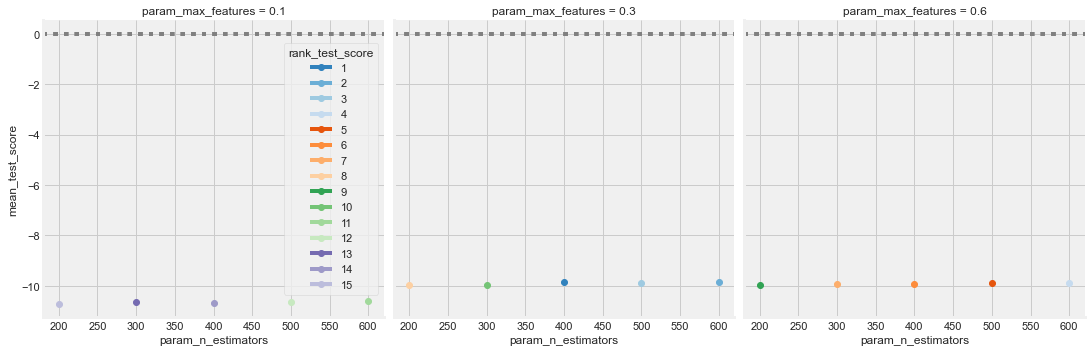

In [50]:
# Model 1: Random Forest Rgressor
import sklearn
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

# Set paramters for Grid Search
param_grid =  {'n_estimators':[200, 300, 400, 500, 600],
               'max_features':[0.1, 0.3, 0.6]
              }
# Initialise the random forest model 
RandForest = RandomForestRegressor(n_jobs= -1, random_state = 0, bootstrap=True)

# Initialise Gridsearch CV with 5 fold corssvalidation and neggative root_mean_squared_error
Tuned_RandForest = GridSearchCV(estimator=RandForest, param_grid=param_grid, scoring='neg_root_mean_squared_error', cv=5)

# Fit model & Time the process for training the model
start_time = time.process_time()
Tuned_RandForest.fit(X_train, y_train)
# End of fit time
print(time.process_time() - start_time, "Seconds")

# Record the results for all models in a pandas dataframe and keep only the best model
Results = pd.DataFrame(Tuned_RandForest.cv_results_)
Results_Best = Results.loc[Results.rank_test_score==1]

print('Random Forest Regressor')
#Results = Results.loc[Results.rank_test_score==1]

# Create a plot to show all models 

col = ['param_max_features']

for col in col:
    grid = sns.FacetGrid(Results, col=col, hue='rank_test_score', palette="tab20c", legend_out=False,
                         col_wrap=5, height=5)

    # Draw a horizontal line to show the starting point
    grid.map(plt.axhline, y=0, ls=":", c=".5")

    # Draw marker on plot and decide what parameters to plot
    grid.map(plt.plot, "param_n_estimators", "mean_test_score", marker="o")

    # Adjust the arrangement of the plots
    grid.fig.tight_layout(w_pad=1)
    
    # Add legend to gird 
    grid.add_legend()

In [33]:
data_all = data.copy()
data_all['month_index'] = 0
data_all['eth_price_usd'] = data_all['eth_price_usd_current']

KeyError: 'eth_price_usd_current'

In [117]:
data_pred = data_all[['valueType_DoublePig','valueType_Visitor','trait_countType','valueType_Human','valueType_Skeleton','valueType_Robot','valueShirt_GlyphShirt','valueType_Elephant','valueType_Pig','valueShirtColor_Magenta','valueGlasses_3D',
    'valueOvershirtColor_Posh','trait_countOvershirt','valueHairStyle_Fade','trait_countHat','valueShoesColor_Purple','valueBeard_MedicalMask','valueOvershirtColor_GreenPlaid',
    'valueShirt_PunkTee','valueShirt_HoodieUp','valueShoes_Basketball','valueShirtColor_Camo','month_index','valueHat_WoolHat','valueHairColor_DyedRed','valueNecklace_GoldChain','valueShirt_Jersey',
    'valueBeardColor_Silver','valuePants_CargoPants','valueShirtColor_Black','valuePantsColor_Magenta','valueHat_Cap','trait_countJerseyNumber','valueShoes_LL86','valueShoes_Classic',
    'valueShirt_CGAShirt','eth_price_usd','valueShoes_LLMoonboots','valueOvershirtColor_Yellow','valuePantsColor_Argyle','trait_countShirtColor','valueShirt_FlamingoTee','valueHatColor_Camo','valueShirt_Lines',
    'valueShoes_LLAlien','trait_countGlasses','trait_countBeard','valueGlassesColor_Charcoal','trait_countNecklace','valuePantsColor_BlueCamo','min_trait_count','valuePants_SuitPants',
    'traits_number','valueShirt_InvaderTee','valuePantsColor_Camo','valueShirt_Windbreaker','valueHat_Headphones','valueShirt_Suit','valueShirt_SnoutzHoodie','valueShoesColor_White',
    'valueHatColor_Magenta','valueShirt_TiedyedTee','valueShirt_Hawaiian','trait_countPantsColor','valueShirtColor_White','valueShirt_SnoutzSkullTee','valueEarring_GoldEarring','valueHat_SnoutzCap',
    'valueShirtColor_Luxe','valueOvershirtColor_Argyle','valuePantsColor_Yellow','valueOvershirtColor_Magenta','valueShirtColor_Posh','valueHairColor_Blue','valueHatColor_Purple','valueShoesColor_Magenta',
    'valueHat_BackwardsCap','valueHatColor_White','trait_countHairColor','valueShoes_LLRGB','valueHatColor_Gray','trait_countHairStyle','valueBeard_Full','valueShirt_StylizedHoodie','valuePantsColor_Purple']]

In [118]:
prediction_all = model.predict(data_pred)
data_pred.loc[:,'pred_price'] = prediction_all


In [119]:
data_pred['token_id'] = df['token_id']
df = pd.merge(df,data_pred[['token_id','pred_price']],left_on='token_id',right_on='token_id',how='inner',copy=False, suffixes=('', '_y'))
df.drop(df.filter(regex='_y$').columns.tolist(),axis=1, inplace=True)

/var/folders/hz/zy00wpxj265fc9j8tfmwsg9r0000gn/T/ipykernel_46095/2646008961.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [120]:
df = df[['token_id', 'image_url','sale_date','sale_price', 'eth_price_usd', 'num_sales',
       'traits_number', 'valueBeard', 'valueBeardColor', 'valueEarring',
       'valueGlasses', 'valueGlassesColor', 'valueHairColor', 'valueHairStyle',
       'valueHat', 'valueHatColor', 'valueJerseyNumber', 'valueNecklace',
       'valueOvershirt', 'valueOvershirtColor', 'valuePants',
       'valuePantsColor', 'valueShirt', 'valueShirtColor', 'valueShoes',
       'valueShoesColor', 'valueTattooMotif', 'valueType', 'min_trait_count',
       'pred_price']]

df.columns

Index(['token_id', 'image_url', 'sale_date', 'sale_price', 'eth_price_usd',
       'num_sales', 'traits_number', 'valueBeard', 'valueBeardColor',
       'valueEarring', 'valueGlasses', 'valueGlassesColor', 'valueHairColor',
       'valueHairStyle', 'valueHat', 'valueHatColor', 'valueJerseyNumber',
       'valueNecklace', 'valueOvershirt', 'valueOvershirtColor', 'valuePants',
       'valuePantsColor', 'valueShirt', 'valueShirtColor', 'valueShoes',
       'valueShoesColor', 'valueTattooMotif', 'valueType', 'min_trait_count',
       'pred_price'],
      dtype='object')

In [121]:
import pandas as pd
import time
import matplotlib.pyplot as plt
import matplotlib as mpl
plt.rc("font", size=14)
import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)
plt.style.use('fivethirtyeight')
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=["#B05E55"])
import plotly.graph_objects as go
import plotly.io as pio


colour_names = ['yellow','red','cyan','brown','orange','blue','purple','grey','darkblue']
colours = ['#edc951','#ee0000','#00a0b0','#4f372d','#eb6841','#336699','#8d2867','#949494','#2d454f']

colors = ['#ee0000','#edc951','#00a0b0','#336699','#8d2867','#949494','#4f372d','#eb6841','#2d454f']

df_all_sorted = df[df['sale_price'] <= df['sale_price'].quantile(q=0.95, interpolation='linear').round(0)]
df_all_sorted = df_all_sorted[df_all_sorted['sale_price'] <= df_all_sorted['pred_price']*10]
df_all_sorted = df_all_sorted.sort_values(by=['sale_price'], ascending=False)

fig = go.Figure()

fig.add_trace(go.Scatter(
                    name="Sale Price",
                    # x = y_test_sorted['valuetype'],
                    y = df_all_sorted['sale_price'].round(3),
                    text=df_all_sorted['token_id'],
                    mode = 'markers',
                    marker = dict(
                        size = 8
                        ,color = '#336699'
                        ,line = dict(width=0.2, color='#fff')
                        ,opacity=0.8
                    ),
                    hovertemplate=
                    "<b>Meebit #%{text}</b><br>" +
                    "Sale price (ETH): %{y:.2f}<br>" +
                    "<extra></extra>"
                    )
                )

fig.add_trace(go.Scatter(
                    name="Predicted Price",
                    # x=y_test_sorted['valuetype'],
                    y=df_all_sorted['pred_price'].round(3),
                    text=df_all_sorted['token_id'],
                    mode = 'markers',
                    marker = dict(
                        size = 8
                        ,color = '#ee0000'
                        ,line= dict(width=0.5, color='#fff')
                        ,opacity=0.3
                    ),
                    hovertemplate=
                    "<b>Meebit #%{text}</b><br>" +
                    "Prediction (ETH): %{y:.2f}<br>" +
                    "<extra></extra>"
                    )
                )
# Change the bar mode
fig.update_layout(
    # title={
    # 'text': value,
    # 'y':0.975,
    # 'x':0.5,
    # 'xanchor': 'center',
    # 'yanchor': 'top'
    # },
    xaxis = {'title':'Count',
            'titlefont': dict(family='sans-serif', size=10, color='#666'),
            'tickangle': 0,
            'showline': True,
            'linewidth': 0.1,
            'linecolor': '#fff',
            'tickformat': ',.0',
            'showspikes': True,
            'spikethickness': 0.5,
            # 'range': [0,1],
            'showgrid': True,
            'gridcolor': '#eee',
            'gridwidth': 0.1
            },
    yaxis = {'title': '',
            'titlefont': dict(family='sans-serif', size=10, color='#222'),
            'ticksuffix': "  ",
            'showspikes': False,
            'spikethickness': 0.5,
            'spikedash': 'solid',
            'showgrid': False,
            'gridcolor': '#fff',
            'gridwidth': 0.01,
            },
    margin = {'l': 50, 'b': 50, 't': 100, 'r': 50},
    showlegend = True,
    # legend = {'x': 0.9, 'y': 1, 'font': dict(family='sans-serif', size=12, color='#222')},#, 'title': dict(text=' WORD ', font=dict(size=15))},
    plot_bgcolor = "#fff",
    paper_bgcolor = "#fff",
    hovermode = 'closest',
    font = dict(
        family="Futura, Helvetica, sans-serif",
        size=10,
        color="#666"
        ),
    legend=dict(
        yanchor="top",
        y=0.99,
        xanchor="left",
        x=0.90)
    )

fig.update_xaxes(categoryorder='total ascending')

# Customize aspect
# fig.update_traces(marker_line_color='rgba(200, 200, 200, 1)',marker_line_width=1, opacity=1)

fig.show()
pio.write_html(fig, file='charts/price_analysis.html', auto_open=True, config=dict(displaylogo=False, displayModeBar=False, showTips=False))


In [3]:
import pandas as pd
dfv = pd.read_csv('https://storage.googleapis.com/trendspotting_general_storage/dw/collections/visualisation_input/meebits_weekly.csv'
    ,sep='\t'
    ,low_memory=True
    ,dtype={
        "token_id": "int16",
        "image_url": "object",
        "rate_date_current":  object,
        "eth_price_usd_current": "float64", 
        "month_index": "float64", 
        "sale_date": object, 
        "flag_is_latest": "int16", 
        "sale_price": "float64", 
        "pred_price": "float64", 
        "current_sale_price": "float64", 
        "opportunity_coef": "float64", 
        "eth_price_usd": "float64", 
        "num_sales": "int16", 
        "traits_number": "int16", 
        "trait_countBeard": "int16", 
        "trait_countBeardColor": "int16", 
        "trait_countEarring": "int16", 
        "trait_countGlasses": "int16", 
        "trait_countGlassesColor": "int16", 
        "trait_countHairColor": "int16", 
        "trait_countHairStyle": "int16", 
        "trait_countHat": "int16", 
        "trait_countHatColor": "int16", 
        "trait_countJerseyNumber": "int16", 
        "trait_countNecklace": "int16", 
        "trait_countOvershirt": "int16", 
        "trait_countOvershirtColor": "int16", 
        "trait_countPants": "int16", 
        "trait_countPantsColor": "int16", 
        "trait_countShirt": "int16", 
        "trait_countShirtColor": "int16", 
        "trait_countShoes": "int16", 
        "trait_countShoesColor": "int16", 
        "trait_countTattooMotif": "int16", 
        "trait_countType": "int16",
        "valueBeard": "category",
        "valueBeardColor": "category",
        "valueEarring": "category",
        "valueGlasses": "category",
        "valueGlassesColor": "category",
        "valueHairColor": "category",
        "valueHairStyle": "category",
        "valueHat": "category",
        "valueHatColor": "category",
        "valueJerseyNumber": "category",
        "valueNecklace": "category",
        "valueOvershirt": "category",
        "valueOvershirtColor": "category",
        "valuePants": "category",
        "valuePantsColor": "category",
        "valueShirt": "category",
        "valueShirtColor": "category",
        "valueShoes": "category",
        "valueShoesColor": "category",
        "valueTattooMotif": "category",
        "valueType": "category",
        "shap_valueType": "float64", 
        "shap_valueShirt": "float64", 
        "shap_valuePants": "float64", 
        "shap_valueShoes": "float64", 
        "shap_valueOvershirt": "float64", 
        "shap_valueHat": "float64", 
        "shap_valueHair": "float64", 
        "shap_valueBeard": "float64", 
        "shap_valueNecklace": "float64", 
        "shap_valueGlasses": "float64", 
        "shap_valueEarring": "float64", 
        "shap_valueTattoo": "float64", 
        "shap_valueOther": "float64", 
        "timestamp": "object"
        }
)

In [7]:
dfv2 = dfv[(dfv['valueType']!='Human') & (dfv['valueType']!='Pig')]
dfv2.to_csv('/Users/michalkollar/Desktop/Personal/Coding/trendspotting_nft/nft_prediction/webapp/dash-gcp/datasets/meebits_weekly_demo.csv',sep='\t')  
dfv2

token_id                                          image_url  \
8             7  https://lh3.googleusercontent.com/xJstPwLSAZ3u...   
175          80  https://lh3.googleusercontent.com/4U0nsOxZCzKi...   
176          80  https://lh3.googleusercontent.com/4U0nsOxZCzKi...   
177          80  https://lh3.googleusercontent.com/4U0nsOxZCzKi...   
178          80  https://lh3.googleusercontent.com/4U0nsOxZCzKi...   
...         ...                                                ...   
32723     19854  https://lh3.googleusercontent.com/qq2EkikAOrcr...   
32759     19879  https://lh3.googleusercontent.com/MPrfn_BtrIDz...   
32760     19879  https://lh3.googleusercontent.com/MPrfn_BtrIDz...   
32814     19920  https://lh3.googleusercontent.com/-HoKaKlvNva6...   
32918     19994  https://lh3.googleusercontent.com/KQ1snQJ1umVt...   

      rate_date_current  eth_price_usd_current  month_index  \
8            2022-01-30            2602.069505          2.0   
175          2022-01-30            2602.069505          5.0   
176          2022-01-30            2602.069505          2.0   
177          2022-01-30            2602.069505          8.0   
178          2022-01-30            2602.069505          6.0   
...                 ...                    ...          ...   
32723        2022-01-30            2602.069505          0.0   
32759        2022-01-30            2602.069505          5.0   
32760        2022-01-30            2602.069505          7.0   
32814        2022-01-30            2602.069505          NaN   
32918        2022-01-30            2602.069505          NaN   

                 sale_date  flag_is_latest    sale_price  pred_price  \
8      2021-11-16 03:08:25               1  3.500000e-01   24.836847   
175    2021-08-30 17:26:04               0  2.000000e-07   23.772356   
176    2021-11-16 19:16:45               1  2.669000e+01   23.772356   
177    2021-05-03 21:59:30               0  2.275000e+01   23.772356   
178    2021-07-20 00:00:38               0  3.900000e-02   23.772356   
...                    ...             ...           ...         ...   
32723  2022-01-21 13:51:35               1  5.000000e+01   61.015747   
32759  2021-08-04 22:06:36               1  1.470000e+02  113.782450   
32760  2021-06-04 05:11:40               0  5.200000e+01  113.782450   
32814                  NaN               1           NaN   19.611467   
32918                  NaN               1           NaN   25.391798   

       current_sale_price  ...  shap_valueOvershirt  shap_valueHat  \
8                     NaN  ...            -0.025471      -0.124169   
175                   NaN  ...            -0.015159      -0.253350   
176                   NaN  ...            -0.015159      -0.253350   
177                   NaN  ...            -0.015159      -0.253350   
178                   NaN  ...            -0.015159      -0.253350   
...                   ...  ...                  ...            ...   
32723                 NaN  ...             0.016718      -0.608139   
32759                 NaN  ...            -0.003349      -2.040339   
32760                 NaN  ...            -0.003349      -2.040339   
32814                 NaN  ...            -0.032805      -0.287776   
32918                 NaN  ...            -0.019562      -0.082208   

       shap_valueHair  shap_valueBeard  shap_valueNecklace  shap_valueGlasses  \
8           -0.436323        -0.031544            0.040974          -0.522742   
175         -0.091382        -0.044756            0.034367          -0.687516   
176         -0.091382        -0.044756            0.034367          -0.687516   
177         -0.091382        -0.044756            0.034367          -0.687516   
178         -0.091382        -0.044756            0.034367          -0.687516   
...               ...              ...                 ...                ...   
32723       -1.350976        -0.004544           -0.049441          -0.159493   
32759       -0.418308        -0.054286            0.849